In [ ]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics 
from keras.models import Sequential
from keras.layers import Dense, LSTM
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
from google.colab import drive

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Dataframe for exploratory analysis
df=pd.read_csv('/content/drive/MyDrive/DataSets/TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-03-08,600.549988,620.130005,558.789978,563.000000,563.000000,51787000
1,2021-03-09,608.179993,678.090027,595.210022,673.580017,673.580017,67523300
2,2021-03-10,700.299988,717.849976,655.059998,668.059998,668.059998,60605700
3,2021-03-11,699.400024,702.500000,677.179993,699.599976,699.599976,36253900
4,2021-03-12,670.000000,694.880005,666.140015,693.729980,693.729980,33583800


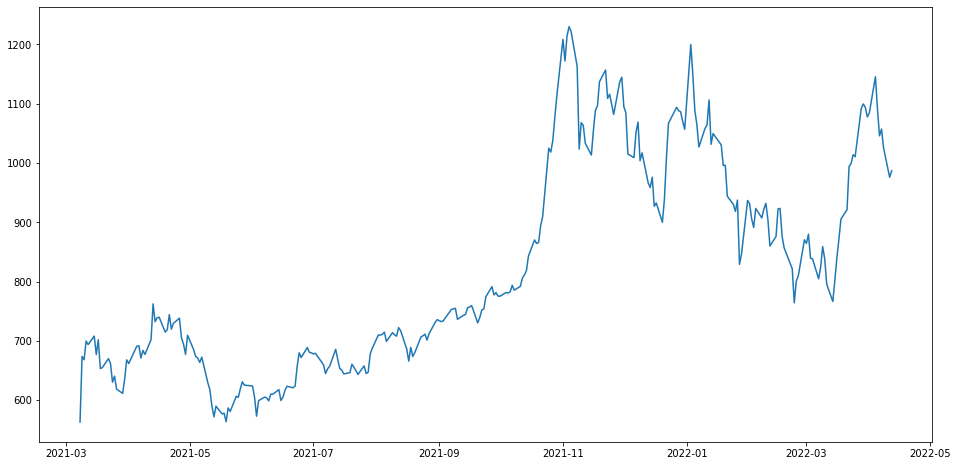

In [ ]:
# Extract date frame and plot closing stock price w.r.t time
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
df.dropna(inplace=True)
#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [ ]:
# fix random seed for reproducibility
np.random.seed(7)

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(df2, look_back=1):
	dataX, dataY = [], []
	for i in range(len(df2)-look_back-1):
		a = df2[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df2[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/DataSets/TSLA.csv', usecols=[5], engine='python')
df2.dropna(inplace=True)
df2 = df2.values
df2 = df2.astype('float32')

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df2 = scaler.fit_transform(df2)

# split into train and test sets
train_size = int(len(df2) * 0.67)
test_size = len(df2) - train_size
train, test = df2[0:train_size,:], df2[train_size:len(df2),:]

In [ ]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(7, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
182/182 - 8s - loss: 0.0562 - 8s/epoch - 41ms/step
Epoch 2/100
182/182 - 1s - loss: 0.0247 - 1s/epoch - 6ms/step
Epoch 3/100
182/182 - 1s - loss: 0.0114 - 926ms/epoch - 5ms/step
Epoch 4/100
182/182 - 1s - loss: 0.0042 - 720ms/epoch - 4ms/step
Epoch 5/100
182/182 - 1s - loss: 0.0025 - 968ms/epoch - 5ms/step
Epoch 6/100
182/182 - 1s - loss: 0.0025 - 883ms/epoch - 5ms/step
Epoch 7/100
182/182 - 1s - loss: 0.0025 - 710ms/epoch - 4ms/step
Epoch 8/100
182/182 - 1s - loss: 0.0025 - 750ms/epoch - 4ms/step
Epoch 9/100
182/182 - 1s - loss: 0.0026 - 654ms/epoch - 4ms/step
Epoch 10/100
182/182 - 1s - loss: 0.0025 - 863ms/epoch - 5ms/step
Epoch 11/100
182/182 - 1s - loss: 0.0025 - 631ms/epoch - 3ms/step
Epoch 12/100
182/182 - 1s - loss: 0.0023 - 692ms/epoch - 4ms/step
Epoch 13/100
182/182 - 1s - loss: 0.0023 - 735ms/epoch - 4ms/step
Epoch 14/100
182/182 - 1s - loss: 0.0024 - 627ms/epoch - 3ms/step
Epoch 15/100
182/182 - 1s - loss: 0.0023 - 692ms/epoch - 4ms/step
Epoch 16/100
182/182 - 1

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df2)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot,color='red')
plt.plot(testPredictPlot,color='green')
plt.show()

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print("Root mean square error = ",trainScore," RMSE")
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print("Root mean square error = ",testScore," RMSE")

Root mean square error =  23.50380156513224  RMSE
Root mean square error =  41.93802551677079  RMSE


In [ ]:
#Text Analysis
columns = ['Date','Category','News']
news = pd.read_csv('/content/drive/MyDrive/DataSets/india-news-headlines.csv', names = columns)
news

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3650966,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650967,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650969,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [ ]:
news.drop(0, inplace=True)
news.drop('Category', axis = 1, inplace=True)
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3650970 entries, 1 to 3650970
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 83.6+ MB


In [ ]:
# Restructuring the date format
news['Date'] = pd.to_datetime(news['Date'],format= '%Y %m %d')
news

,Date,News
1,2001-01-02 00:00:00.000000000,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02 00:00:00.000000000,Fissures in Hurriyat over Pak visit
3,2001-01-02 00:00:00.000000000,America's unwanted heading for India?
4,2001-01-02 00:00:00.000000000,For bigwigs; it is destination Goa
5,2001-01-02 00:00:00.000000000,Extra buses to clear tourist traffic
...,...,...
3650966,1970-01-01 00:00:00.020220331,J&K sacks 2 cops; 3 other employees over terro...
3650967,1970-01-01 00:00:00.020220331,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,1970-01-01 00:00:00.020220331,As Covid-19 cases drop to nil in southern dist...
3650969,1970-01-01 00:00:00.020220331,Tamil Nadu sees marginal rise of Covid cases w...


In [ ]:
#Grouping the headlines for each day
news['News'] = news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
news = news.drop_duplicates() 
news.reset_index(inplace = True, drop = True)
news

,Date,News
0,2001-01-02 00:00:00.000000000,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03 00:00:00.000000000,Powerless north India gropes in the dark Think...
2,2001-01-04 00:00:00.000000000,The string that pulled Stephen Hawking to Indi...
3,2001-01-05 00:00:00.000000000,Light combat craft takes India into club class...
4,2001-01-06 00:00:00.000000000,Light combat craft takes India into club class...
...,...,...
7713,1970-01-01 00:00:00.020220327,Playing a dead man in Body God meant sitting i...
7714,1970-01-01 00:00:00.020220328,As fashion becomes democratic; demand for styl...
7715,1970-01-01 00:00:00.020220329,Bobby Deol: Like my dad; I hope to be working ...
7716,1970-01-01 00:00:00.020220330,I will not give in to trends: Dossmode The tim...


In [ ]:
news['News']

0       Status quo will not be disturbed at Ayodhya; s...
1       Powerless north India gropes in the dark Think...
2       The string that pulled Stephen Hawking to Indi...
3       Light combat craft takes India into club class...
4       Light combat craft takes India into club class...
                              ...                        
7713    Playing a dead man in Body God meant sitting i...
7714    As fashion becomes democratic; demand for styl...
7715    Bobby Deol: Like my dad; I hope to be working ...
7716    I will not give in to trends: Dossmode The tim...
7717    Shashank goes back to coastal Karnataka and Mo...
Name: News, Length: 7718, dtype: object

In [ ]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [ ]:
#Adding subjectivity and polarity columns
news['Subjectivity'] = news['News'].apply(getSubjectivity)
news['Polarity'] = news['News'].apply(getPolarity)
news

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,News,Subjectivity,Polarity
0,2001-01-02 00:00:00.000000000,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333
1,2001-01-03 00:00:00.000000000,Powerless north India gropes in the dark Think...,0.407692,0.088462
2,2001-01-04 00:00:00.000000000,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961
3,2001-01-05 00:00:00.000000000,Light combat craft takes India into club class...,0.476612,0.262024
4,2001-01-06 00:00:00.000000000,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7713,1970-01-01 00:00:00.020220327,Playing a dead man in Body God meant sitting i...,0.369592,0.025109
7714,1970-01-01 00:00:00.020220328,As fashion becomes democratic; demand for styl...,0.389939,0.055878
7715,1970-01-01 00:00:00.020220329,Bobby Deol: Like my dad; I hope to be working ...,0.404240,0.095198
7716,1970-01-01 00:00:00.020220330,I will not give in to trends: Dossmode The tim...,0.350965,0.037729


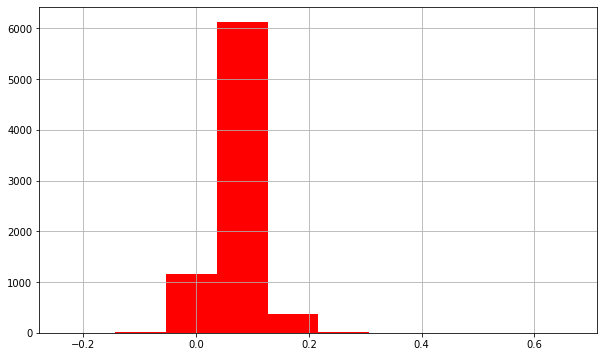

In [ ]:
plt.figure(figsize = (10,6))
news['Polarity'].hist(color = 'red')

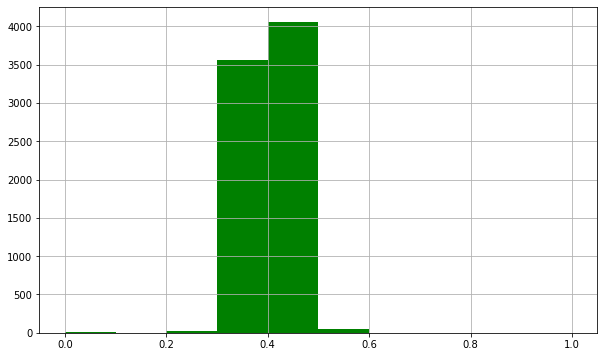

In [ ]:
plt.figure(figsize = (10,6))
news['Subjectivity'].hist(color = 'green')

In [ ]:
#Adding sentiment score to news
sia = SentimentIntensityAnalyzer()

news['Compound'] = [sia.polarity_scores(v)['compound'] for v in news['News']]
news['Negative'] = [sia.polarity_scores(v)['neg'] for v in news['News']]
news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in news['News']]
news['Positive'] = [sia.polarity_scores(v)['pos'] for v in news['News']]
news

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
merge = news
merge

In [ ]:
dff = merge[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
dff

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(dff))
new_df.columns = dff.columns
new_df.index = dff.index
new_df.head()

In [ ]:
X = new_df[0:249]
y =df['Close']

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

In [ ]:
x_train[:10]

In [ ]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [ ]:
print(prediction[:10])
print(y_test[:10])
print("Root mean square error = ",math.sqrt(mean_squared_error(prediction,y_test))," RMSE")

In [ ]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [ ]:
print("Root mean square error = ",math.sqrt(mean_squared_error(predictions, y_test))," RMSE")